In [1]:
# import standard libraries
from datetime import timedelta
import glob
import os
import re
import string
# import third-party libraries
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import seaborn as sns
# import local libraries
from mlf import read_patent_file, TICK_NAME

## Download packages and declare some constants for NLP

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/williammartin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/williammartin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/williammartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# define english stopwords
en_stop = set(nltk.corpus.stopwords.words('english'))

## Download data

In [6]:
filepaths = glob.glob('data/patents/raw/*.gz')
data = [read_patent_file(f) for f in filepaths]

In [7]:
# read all dataframes in one big dataframe
patents = pd.concat(data, axis=0)

# Exploratory data analysis

In [8]:
patents.dropna(how='all', inplace=True, axis=1)

In [9]:
numeric_col = ['cited_patent_number', 'citedby_patent_number', 'num_inventor',
              'patent_num_claims', 'patent_processing_time']
date_col = ['app_date', 'patent_date']
text_col = ['cpc_group_title', 'cpc_subgroup_title', 'cpc_subsection_title',
            'nber_subcategory_title', 'patent_abstract', 'patent_title', 
            'uspc_mainclass_title', 'uspc_subclass_title',
            'wipo_field_title', 'wipo_sector_title']

In [10]:
# change type of certain columns
patents[numeric_col] = patents[numeric_col].astype(np.float64)

In [11]:
# change date columns to datetime objects
for col in date_col:
    patents[col] = pd.to_datetime(patents[col], format='%Y-%m-%d')

In [12]:
patents.shape

(11098, 21)

In [13]:
patents.columns

Index(['app_date', 'app_number', 'assignee_organization',
       'cited_patent_number', 'citedby_patent_number', 'cpc_group_title',
       'cpc_subgroup_title', 'cpc_subsection_title', 'num_inventor',
       'nber_subcategory_title', 'patent_abstract', 'patent_date',
       'patent_num_claims', 'patent_number', 'patent_processing_time',
       'patent_title', 'uspc_mainclass_title', 'uspc_subclass_title',
       'wipo_field_title', 'wipo_sector_title', 'ticker'],
      dtype='object')

In [14]:
# get number of missing observations in each column
patents_missing = patents.isna().sum()
patents_missing = patents_missing[patents_missing > 0]
pd.DataFrame(data = patents_missing, columns=['#nan'])

,#nan
cpc_group_title,532
cpc_subgroup_title,532
cpc_subsection_title,532
nber_subcategory_title,7742
patent_abstract,360
uspc_mainclass_title,3319
uspc_subclass_title,7548
wipo_field_title,534
wipo_sector_title,534


Most features that have nan values are actually text cells, all the rest seems good. Let's concantenate all text info together for some NLP

<AxesSubplot:xlabel='citedby_patent_number', ylabel='Count'>

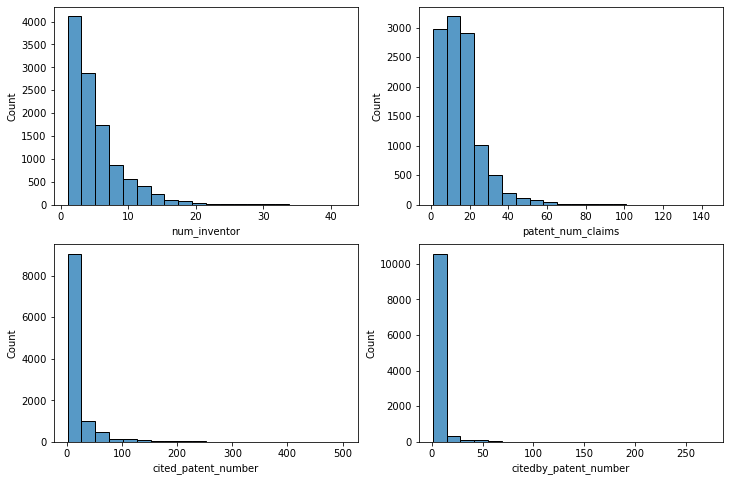

In [15]:
# plot histogram of numerical features
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
sns.histplot(patents['num_inventor'], bins=20, ax=ax[0, 0])
sns.histplot(patents['patent_num_claims'], bins=20, ax=ax[0, 1])
sns.histplot(patents['cited_patent_number'], bins=20, ax=ax[1, 0])
sns.histplot(patents['citedby_patent_number'], bins=20, ax=ax[1, 1])

In [16]:
# investigate dates
patents[date_col].describe()

<ipython-input-16-87461276fdf9>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  patents[date_col].describe()
<ipython-input-16-87461276fdf9>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  patents[date_col].describe()


,app_date,patent_date
count,11098,11098
unique,2325,506
top,2013-03-15 00:00:00,2017-05-23 00:00:00
freq,49,45
first,2010-01-04 00:00:00,2010-08-31 00:00:00
last,2019-12-20 00:00:00,2020-09-29 00:00:00


In [17]:
# investigate occurences of wipo sector accross years
wipo_sector = patents[['patent_date', 'wipo_sector_title']]
wipo_sector = wipo_sector.sort_values('patent_date')
wipo_sector['year'] = wipo_sector['patent_date'].apply(lambda x: x.year)
wipo_sector = wipo_sector.drop(columns='patent_date').reset_index(drop=True)
wipo_sector = wipo_sector.dropna(how='any')
wipo_sector['wipo_sector_title'] = wipo_sector['wipo_sector_title'].str.split(' ')
wipo_sector['wipo_sector_title'] = wipo_sector['wipo_sector_title'].apply(lambda x: list(set(x)))
wipo_sector = wipo_sector.explode('wipo_sector_title')
wipo_sector = wipo_sector[(wipo_sector['year'] < 2020) & (wipo_sector['year'] > 2011)]

<AxesSubplot:xlabel='year', ylabel='count'>

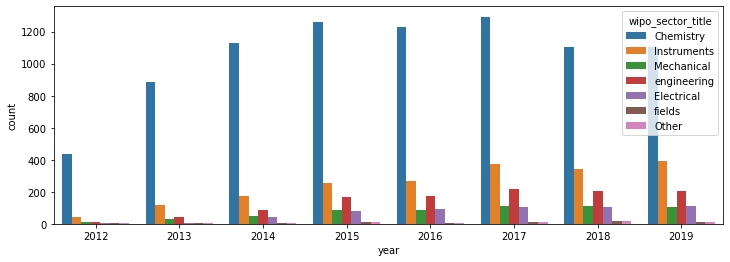

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x='year', data=wipo_sector, hue='wipo_sector_title', ax=ax)

In [19]:
# investigate wipo fields across the years
wipo_field = patents[['patent_date', 'wipo_field_title']]
wipo_field = wipo_field.sort_values('patent_date')
wipo_field['year'] = wipo_field['patent_date'].apply(lambda x: x.year)
wipo_field = wipo_field.drop(columns='patent_date').reset_index(drop=True)
wipo_field = wipo_field.dropna(how='any')
wipo_field['wipo_field_title'] = wipo_field['wipo_field_title'].apply(lambda x: re.findall('[A-Z][^A-Z]*', x))
wipo_field['wipo_field_title'] = wipo_field['wipo_field_title'].apply(lambda x: list(set(x)))
wipo_field = wipo_field.explode('wipo_field_title')
wipo_field['wipo_field_title'] = wipo_field['wipo_field_title'].str.strip()
wipo_field = wipo_field[(wipo_field['year'] < 2020) & (wipo_field['year'] > 2011)]

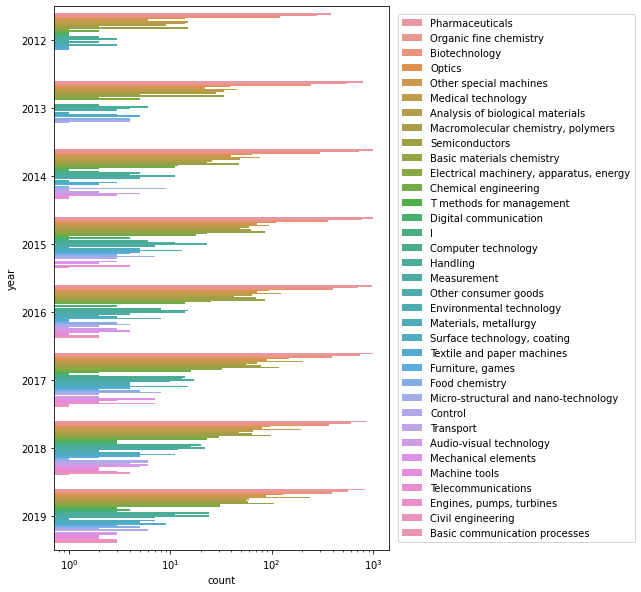

In [20]:
fig, ax = plt.subplots(figsize=(6, 10))
ax = sns.countplot(y='year', data=wipo_field, hue='wipo_field_title', ax=ax)
ax.legend(loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
ax.set_xscale('log')

# Data cleaning

In [21]:
# remove patent date beyond 2019-12-31
patents_cleaned = patents[patents['patent_date'] <= '2019-12-31']

In [22]:
last_patent_date = patents_cleaned['patent_date'].max()
# since we are trying to predict returns x days after patent date, we need to filter again 
# we assume the maximum value for x to be 30 days
patents_cleaned = patents_cleaned[patents_cleaned['patent_date'] <= last_patent_date-timedelta(days=30)]

In [23]:
patents_cleaned.shape

(10063, 21)

## Text cleaning

In [24]:
# clean nan strings
patents_cleaned[text_col] = patents_cleaned[text_col].fillna('')

In [25]:
# create column with all text
patents_cleaned['text'] = patents_cleaned[text_col].apply(lambda x: ' '.join(x), axis=1)

In [26]:
# remove all other text columns
patents_cleaned = patents_cleaned.drop(columns=text_col)

In [27]:
# define some function that cleans text and tokenizes
def tokenize(text):
    # remove any non alphanumeric character
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    # lowercase
    text = text.lower()
    # handle numbers
    text = re.sub('[0-9]+', 'number', text)
    # handle urls
    text = re.sub('(http|https)://[^\s]*', '', text)
    # handle email adresses
    text = re.sub('[^\s]+@[^\s]+', '', text)
    # handle $ sign
    text = re.sub('[$]+', 'dollar', text)
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove the extra spaces between words
    text = re.sub(' +', ' ', text)
    # tokenize
    tokens = word_tokenize(text)
    
    return tokens

In [28]:
# remove words that are smaller than 2 characters
def remove_smallwords(tokens):
    return [t for t in tokens if len(t) > 2]

In [29]:
# filter out stopwords from the english dictionary
def remove_stopwords(tokens):
    return [t for t in tokens if t not in en_stop]

In [30]:
# use morphy to lemmatize in a first step
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [31]:
# user WordNetLemmatizer to lemmatize in a second step (removes conjugation for example)
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [32]:
def text_lda(text):
    tokens = tokenize(text)
    tokens = remove_smallwords(tokens)
    tokens = remove_stopwords(tokens)
    tokens = [get_lemma(t) for t in tokens]
    tokens = [get_lemma2(t) for t in tokens]
    return tokens

In [33]:
# perform text cleaning, tokenization and lemmatization of text of every patent
patents_cleaned['text'] = patents_cleaned['text'].apply(text_lda)

In [34]:
# add a column with number of unique tokens
patents_cleaned['num_tokens'] = patents_cleaned['text'].apply(lambda x: len(list(set(x))))

In [35]:
patents_cleaned['num_tokens'].describe()

count    10063.000000
mean       128.020670
std         55.378072
min          1.000000
25%         93.000000
50%        122.000000
75%        159.000000
max        475.000000
Name: num_tokens, dtype: float64

In [36]:
# we need to remove patents that have very little text 
# decide to remove patents that have less than 50 unique tokens
patents_cleaned = patents_cleaned[patents_cleaned['num_tokens'] >= 50]

In [37]:
patents_cleaned['num_tokens'].describe()

count    9583.000000
mean      133.520714
std        50.722321
min        50.000000
25%        97.000000
50%       125.000000
75%       161.000000
max       475.000000
Name: num_tokens, dtype: float64

In [38]:
patents_cleaned = patents_cleaned.drop(columns=['num_tokens'])

In [39]:
# join list of tokens into text before saving to csv
patents_cleaned['text'] = patents_cleaned['text'].apply(lambda x: ' '.join(x))

In [40]:
# save to csv
filename = 'data/patents/clean/patents.csv.gz'
patents_cleaned.to_csv(filename, compression='gzip', index=False)